# Lifetimes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

import pairinteraction.real as pi

In [2]:
if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

In [3]:
ket = pi.KetAtom("Rb", n=60, l=0, j=0.5, m=0.5)

T_in_K = 300
lifetime_0 = ket.get_lifetime()
lifetime = ket.get_lifetime(T_in_K, temperature_unit="K")

print(f"Lifetime at T=0: {lifetime_0.to('mus'):.2f}")
print(f"Lifetime at T={T_in_K}K: {lifetime.to('mus'):.2f}")

Lifetime at T=0: 241.79 microsecond
Lifetime at T=300K: 101.60 microsecond


Number of possible spontaneous decay transitions: 275
Number of considered BBR transitions: 430


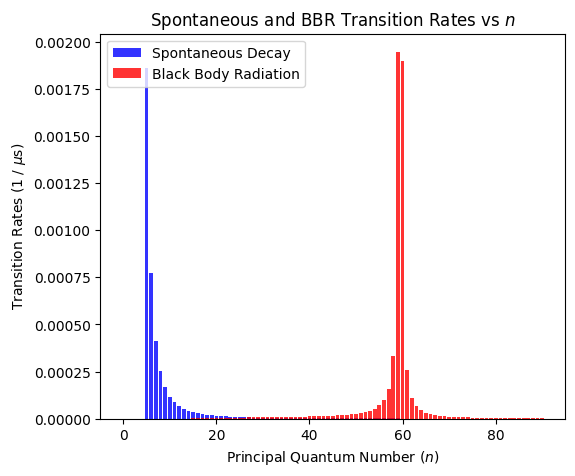

In [10]:
kets_sp, transition_rates_sp = ket.get_spontaneous_transition_rates(unit="1/mus")
print(f"Number of possible spontaneous decay transitions: {len(transition_rates_sp)}")

kets_bbr, transition_rates_bbr = ket.get_black_body_transition_rates(T_in_K, "kelvin", unit="1/mus")
print(f"Number of considered BBR transitions: {len(transition_rates_bbr)}")

fig, ax = plt.subplots(figsize=(6, 5))

n_list = np.arange(0, np.max([s.n for s in kets_bbr]) + 1)
rates_summed = {}
for key, kets, rates in [("BBR", kets_bbr, transition_rates_bbr), ("SP", kets_sp, transition_rates_sp)]:
    rates_summed[key] = np.zeros(len(n_list))
    for i, s in enumerate(kets):
        rates_summed[key][s.n] += rates[i]

ax.bar(n_list, rates_summed["SP"], label="Spontaneous Decay", color="blue", alpha=0.8)
ax.bar(n_list, rates_summed["BBR"], label="Black Body Radiation", color="red", alpha=0.8)
ax.legend()

ax.set_xlabel("Principal Quantum Number ($n$)")
ax.set_ylabel(r"Transition Rates (1 / $\mu$s)")
ax.set_title("Spontaneous and BBR Transition Rates vs $n$")

plt.show()

In [5]:
n_list = list(range(30, 90, 5))


def fit_function(x: np.ndarray, a: float, b: float) -> np.ndarray:
    return a * x + b


# S states
kets_s = [pi.KetAtom("Rb", n=n, l=0, j=0.5, m=0.5) for n in n_list]
nu_s = [ket.nu for ket in kets_s]
lifetimes_s = [ket.get_lifetime(unit="mus") for ket in kets_s]
popt_s, _ = curve_fit(fit_function, np.log(nu_s), np.log(lifetimes_s))

# circular states
kets_circular = [pi.KetAtom("Rb", n=n, l=n - 1, j=n - 0.5, m=n - 0.5) for n in n_list]
nu_circular = [ket.nu for ket in kets_circular]
lifetimes_circular = [ket.get_lifetime(unit="mus") for ket in kets_circular]
popt_circular, _ = curve_fit(fit_function, np.log(nu_circular), np.log(lifetimes_circular))

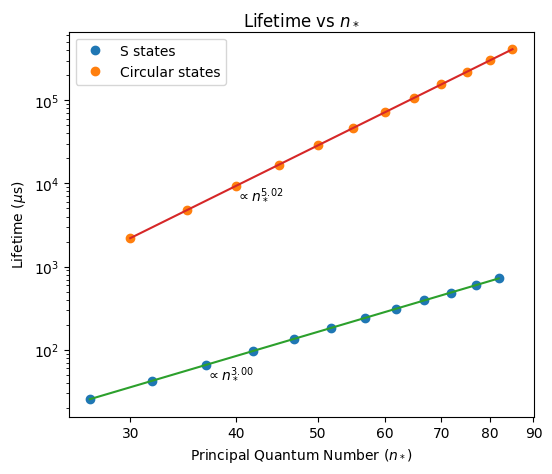

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(nu_s, lifetimes_s, "o", label="S states")
ax.plot(nu_circular, lifetimes_circular, "o", label="Circular states")

fit_s = np.exp(fit_function(np.log(nu_s), *popt_s))
fit_circular = np.exp(fit_function(np.log(nu_circular), *popt_circular))
ax.plot(nu_s, fit_s)
ax.plot(nu_circular, fit_circular)

ax.text(nu_s[2], fit_s[2], rf"$\propto n_*^{{{popt_s[0]:.2f}}}$", verticalalignment="top")
ax.text(nu_circular[2], fit_circular[2], rf"$\propto n_*^{{{popt_circular[0]:.2f}}}$", verticalalignment="top")

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Principal Quantum Number ($n_*$)")
ax.set_ylabel(r"Lifetime ($\mu$s)")
ax.set_title("Lifetime vs $n_*$")

ax.set_xticks([30, 40, 50, 60, 70, 80, 90])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.show()